In [190]:
import csv
import matplotlib.pyplot as plt
import random
import numpy as np
from sklearn.linear_model import LogisticRegression

In [3]:
data = []
with open('shot_logs.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quotechar='"')
    for row in reader:
        for row in reader:
            data.append(row)

In [4]:
categories = ['game_id','matchup','location','win/lose','final_margin','shot_number','period','game_clock',
             'shot_clock','dribbles','touch_time','shot_dist','pts_type','shot_result','closest_def_name',
             'closest_def_id','closest_def_dist','fgm','pts','player_name', 'player_id']

shot_dict = {}
for i in range(len(data)):
    shot_dict[i] = dict(zip(categories, data[i]))

In [5]:
labels = [int(shot_dict[i]['fgm']) for i in range(len(data))]

In [6]:
dribbles = [float(shot_dict[i]['dribbles']) for i in range(len(data))]
shot_dist = [float(shot_dict[i]['shot_dist']) for i in range(len(data))]
pts_type = [float(shot_dict[i]['pts_type']) for i in range(len(data))]
closest_def_dist = [float(shot_dict[i]['closest_def_dist']) for i in range(len(data))] 

In [74]:
shot_dict[0]['final_margin']

'24'

# Data cleanup

In [57]:
# Cleaning shot_dict
for i in range(len(data)):
    if shot_dict[i]['shot_clock'] == '':
        shot_dict[i]['shot_clock'] = 0
    if shot_dict[i]['dribbles'] == '':
         shot_dict[i]['dribbles'] = 0
            
    if shot_dict[i]['location'] == 'A':
        shot_dict[i]['location'] = 0
    else:
        shot_dict[i]['location'] = 1
        
    if shot_dict[i]['win/lose'] == 'L':
        shot_dict[i]['win/lose'] = 0
    else:
        shot_dict[i]['win/lose'] = 1

# Ratio plots

In [61]:
def createPlot(category):
    cat_data = [float(shot_dict[i][category]) for i in range(len(data))]
    cat_zip = list(zip(cat_data,labels))
    made = [d[0] for d in cat_zip if d[1] == 1]
    x_axis = range(len(range(0,int(max(made)+2))))
    made_counts, _= np.histogram(made,x_axis)
    notmade = [d[0] for d in cat_zip if d[1] == 0]
    notmade_counts, _= np.histogram(notmade,x_axis)

    ratio = np.divide(made_counts, made_counts+notmade_counts)
    return ratio, x_axis[:-1]

In [75]:
categories = ['dribbles', 'shot_clock', 'shot_dist', 'pts_type','closest_def_dist', 'touch_time', 'location',
             'win/lose', 'period', 'final_margin']

/Users/ryanle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


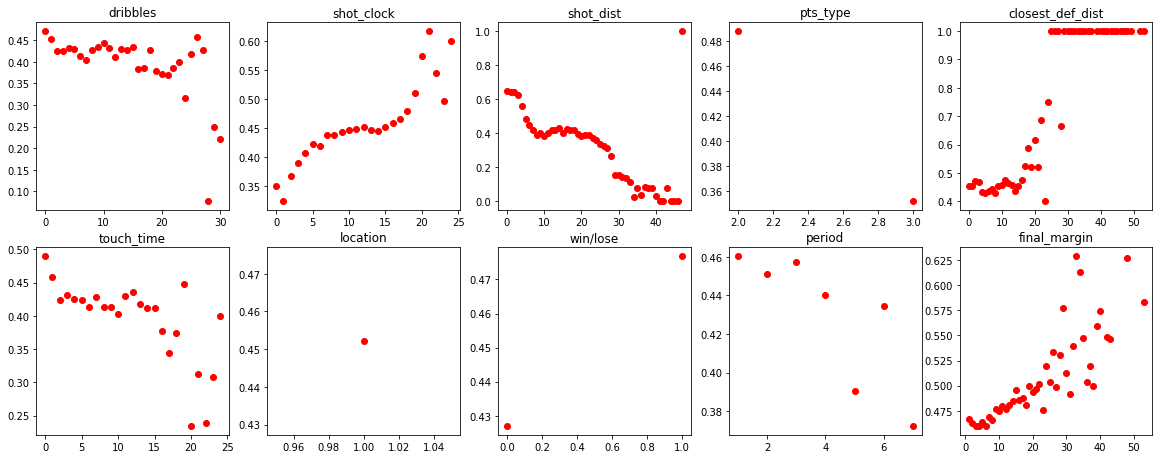

In [76]:
fig = plt.figure(figsize=(20,20))
for i in range(len(categories)):
    ratio, x_axis = createPlot(categories[i])
    ax1 = fig.add_subplot(len(categories)/2,len(categories)/2, i+1)
    plt.title(categories[i])
    plt.plot(x_axis, ratio, 'ro')

# Player Analysis

In [95]:
player_names = set([shot_dict[i]['player_name'] for i in range(len(data))])
player_ids = set([shot_dict[i]['player_id'] for i in range(len(data))])

name_to_id = {}
id_to_name = {}
for i in range(len(data)):
    name_to_id[shot_dict[i]['player_name']] = shot_dict[i]['player_id']
    id_to_name[shot_dict[i]['player_id']] = shot_dict[i]['player_name']

In [175]:
player_data = []
with open('players.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quotechar='"')
    for row in reader:
        for row in reader:
            player_data.append(row)

In [176]:
# Making names lower case to keep uniform
for d in player_data:
    d[0] = d[0].lower()

In [177]:
# Converting the positions to numbers
for d in player_data:
    if d[1][:2] == "PG":
        d[1] = 1
    elif d[1][:2] == "SG":
        d[1] = 2
    elif d[1][:2] == "SF":
        d[1] = 3
    elif d[1][:2] == "PF":
        d[1] = 4
    elif d[1][:2] == "C":
        d[1] = 5

In [178]:
player_cats = ['player','pos','fg','3p','2p','efg','ppg']

In [179]:
player_dict = {} # Dictionary of players with player id's as keys
for d in player_data:
    if d[0] in player_names:
        pid = name_to_id[d[0]]
        player_dict[pid] = dict(zip(player_cats, d))

In [180]:
def getPlayerStats(name):
    return player_dict[name_to_id[name]]

In [182]:
player_dict[name_to_id['goran dragic']]['pos']

2

In [183]:
pids = list(player_ids)
ppg = []
fg = []
fg3 = []
efg = []
pos = []
for pid in pids:
    if pid in set(player_dict.keys()):
        if player_dict[pid]['ppg'] == "":
            ppg.append(0)
        else:
            ppg.append(float(player_dict[pid]['ppg']))
        if player_dict[pid]['fg'] == "":
            fg.append(0)
        else:
            fg.append(float(player_dict[pid]['fg']))
        if player_dict[pid]['3p'] == "":
            fg3.append(0)
        else:
            fg3.append(float(player_dict[pid]['3p']))
        if player_dict[pid]['efg'] == "":
            efg.append(0)
        else:
            efg.append(float(player_dict[pid]['efg']))
        if player_dict[pid]['pos'] == "":
            pos.append(0)
        else:
            pos.append(float(player_dict[pid]['pos']))

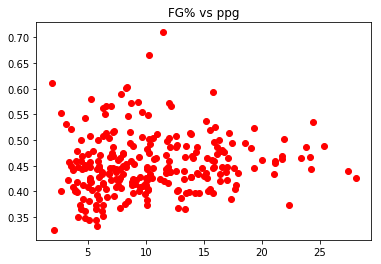

In [184]:
plt.title("FG% vs ppg")
plt.plot(ppg, fg, 'ro')

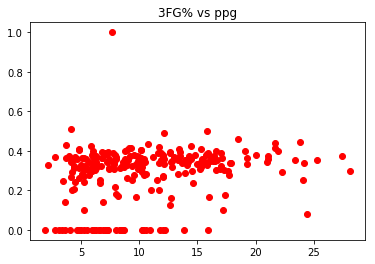

In [185]:
plt.title("3FG% vs ppg")
plt.plot(ppg, fg3, 'ro')

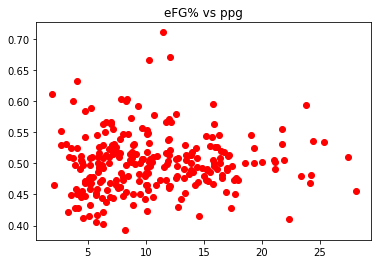

In [186]:
plt.title("eFG% vs ppg")
plt.plot(ppg, efg, 'ro')

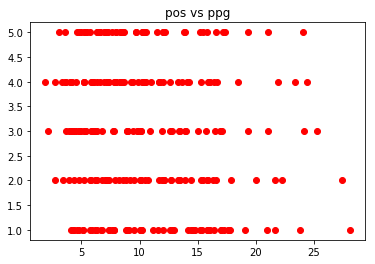

In [189]:
plt.title("pos vs ppg")
plt.plot(ppg, pos, 'ro')

# Model Attempts

In [203]:
# Sampling training sets and test sets
shot_list = list(zip(shot_dict.keys(),shot_dict.values()))
random.shuffle(shot_list)

train_set = shot_list[:len(shot_list)//2]
test_set = shot_list[len(shot_list)//2:]

In [205]:
train_set[0]

(90279,
 {'closest_def_dist': '9.4',
  'closest_def_id': '202696',
  'closest_def_name': 'Vucevic, Nikola',
  'dribbles': '6',
  'fgm': '0',
  'final_margin': '-14',
  'game_clock': '2:02',
  'game_id': '21400150',
  'location': 1,
  'matchup': 'NOV 17, 2014 - DET vs. ORL',
  'period': '1',
  'player_id': '201943',
  'player_name': 'brandon jennings',
  'pts': '0',
  'pts_type': '2',
  'shot_clock': '1.1',
  'shot_dist': '19.4',
  'shot_number': '6',
  'shot_result': 'missed',
  'touch_time': '6.2',
  'win/lose': 0})

In [207]:
def feature1(datum):
    feat = [1]
    feat.append(float(datum['shot_clock']) if datum['shot_clock'] != "" else 0)
    feat.append(float(datum['shot_dist']) if datum['shot_dist'] != "" else 0)
    feat.append(float(datum['touch_time']) if datum['touch_time'] != "" else 0)
    
    return feat

In [209]:
X_train = [feature1(d[1]) for d in train_set]
y_train = [float(d[1]['fgm']) for d in train_set]

X_test = [feature1(d[1]) for d in test_set]
y_test = [float(d[1]['fgm']) for d in test_set]

In [214]:
# Logistic Regression
clf = LogisticRegression().fit(X_train, y_train)

train_preds = clf.predict(X_train)
train_acc = sum([1 for a,b in zip(y_train,train_preds) if a==b]) / len(y_train)

test_preds = clf.predict(X_test)
test_acc = sum([1 for a,b in zip(y_test,test_preds) if a==b]) / len(y_test)

print("Train accuracy: ", train_acc, "Test accuracy: ", test_acc)

Train accuracy:  0.603569978448949 Test accuracy:  0.6020301397673148


In [216]:
len(X_train)

64034